In [1]:
!pip install yfinance
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import clear_output
import datetime
clear_output()

In [2]:
plt.rcParams["figure.figsize"] = (14,10)
plt.rcParams.update({'font.size': 20})

# **Dividend Discount Model**

**The dividend discount model (DDM) is a quantitative method used for predicting the price of a company's stock based on the theory that its present-day price is worth the sum of all of its future dividend payments when discounted back to their present value.**

<sup>Source: [Dividend Discount Model – DDM](https://www.investopedia.com/terms/d/ddm.asp) from Investopedia.com by James Chen</sup>

## **Gordon Growth Model**

**The Gordon growth model is used to determine the intrinsic value of a stock based on a future series of dividends that grow at a constant rate.**

$\Large{\text{Estimated Stock Value} = \frac{\text{Expected Dividend per Share}}{\text{Cost of Equity}-\text{Dividend Growth Rate}}}$ 

\

$\large{\text{Where: Cost of Equity = Risk Free Rate + β(Market Return-Risk Free Rate)}}\\ \large{\text{Dividend Growth Rate = (Return on Equity)(1-Payout Ratio)}}$

<sup>Source: [Gordon Growth Model](https://www.investopedia.com/terms/g/gordongrowthmodel.asp) from Investopedia.com by Adam Hayes</sup>

<sup>Source: [The Stable Growth DDM: Gordon Growth Model](https://www.investopedia.com/terms/d/ddm.asp) by Aswath Damodaran</sup>

In [3]:
stanley_bd = yf.Ticker('SWK')

In [9]:
beta = stanley_bd.info['beta']
risk_free_rate = yf.Ticker('^TNX').get_info()['previousClose']*.01
market_return = .11

cost_of_equity = risk_free_rate + beta *(market_return-risk_free_rate)
cost_of_equity

0.14632547216

In [10]:
div_growth_rate = stanley_bd.info['returnOnEquity'] * (1-stanley_bd.get_info()['payoutRatio'])
div_growth_rate

0.12448867200000002

In [11]:
div_per_share = stanley_bd.get_info()['previousClose'] * stanley_bd.info['dividendYield']
div_per_share

3.168816

In [12]:
def ggm_model(div_per_share,cost_of_equity,div_growth_rate):
  return div_per_share/(cost_of_equity-div_growth_rate)

In [13]:
ggm_forecasted_price = ggm_model(div_per_share,cost_of_equity,div_growth_rate)
print(f'The Gordon Growth Model forecasts the SWK stock price at: ${ggm_forecasted_price:.2f}')

The Gordon Growth Model forecasts the SWK stock price at: $145.11


In [14]:
market_return_array = np.arange(.1,.25,.01)
ggm_mr_estimates = [div_per_share/((risk_free_rate + beta * (estimate - risk_free_rate)) - div_growth_rate) for estimate in market_return_array]

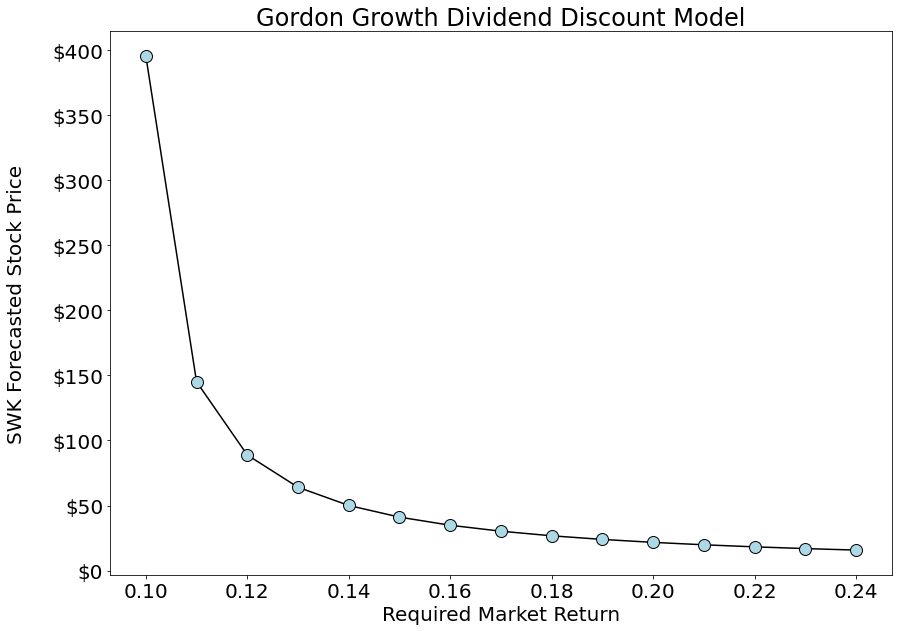

In [15]:
plt.plot(market_return_array,ggm_mr_estimates,color='black', marker='o',markerfacecolor='lightblue', markevery=1,markersize=12)
plt.ylabel('SWK Forecasted Stock Price\n')
plt.xlabel('Required Market Return')
price_label = ['$'+str(num) for num in range(0,450,50)]
plt.yticks(range(0,450,50),price_label)
plt.title('Gordon Growth Dividend Discount Model');

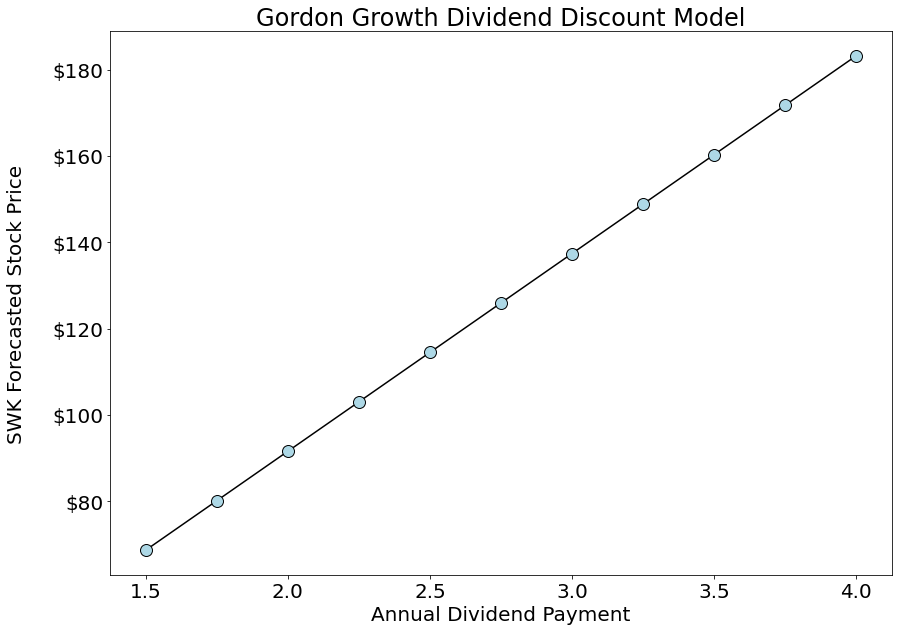

In [16]:
div_array = np.arange(1.5,4.25,.25)
ggm_div_estimates = [ggm_model(div,cost_of_equity,div_growth_rate) for div in div_array]

plt.plot(div_array,ggm_div_estimates,color='black', marker='o',markerfacecolor='lightblue', markevery=1,markersize=12)
plt.ylabel('SWK Forecasted Stock Price\n')
plt.xlabel('Annual Dividend Payment')
price_label = ['$'+str(num) for num in range(80,200,20)]
plt.yticks(range(80,200,20),price_label)
plt.title('Gordon Growth Dividend Discount Model');

## **Multistage Dividend Discount Model**



**The multistage dividend discount model is an equity valuation model that builds on the Gordon growth model by applying varying growth rates to the calculation.**

$\Large{\text{Estimated Stock Value} = \sum_{i=1}^N} \frac{\text{Expected Dividend}_i}{(1+\text{Cost of Equity})^{T_i}} + \frac{\text{Expected Dividend}_N (\frac{1+\text{Dividend Growth Rate}}{\text{Cost of Equity - Dividend Growth Rate}})}{(1+\text{Cost of Equity})^{T_N}}$ 

<sup>Source: [Multistage Dividend Discount Model](https://www.investopedia.com/terms/m/multistageddm.asp) from Investopedia.com by James Chen</sup>

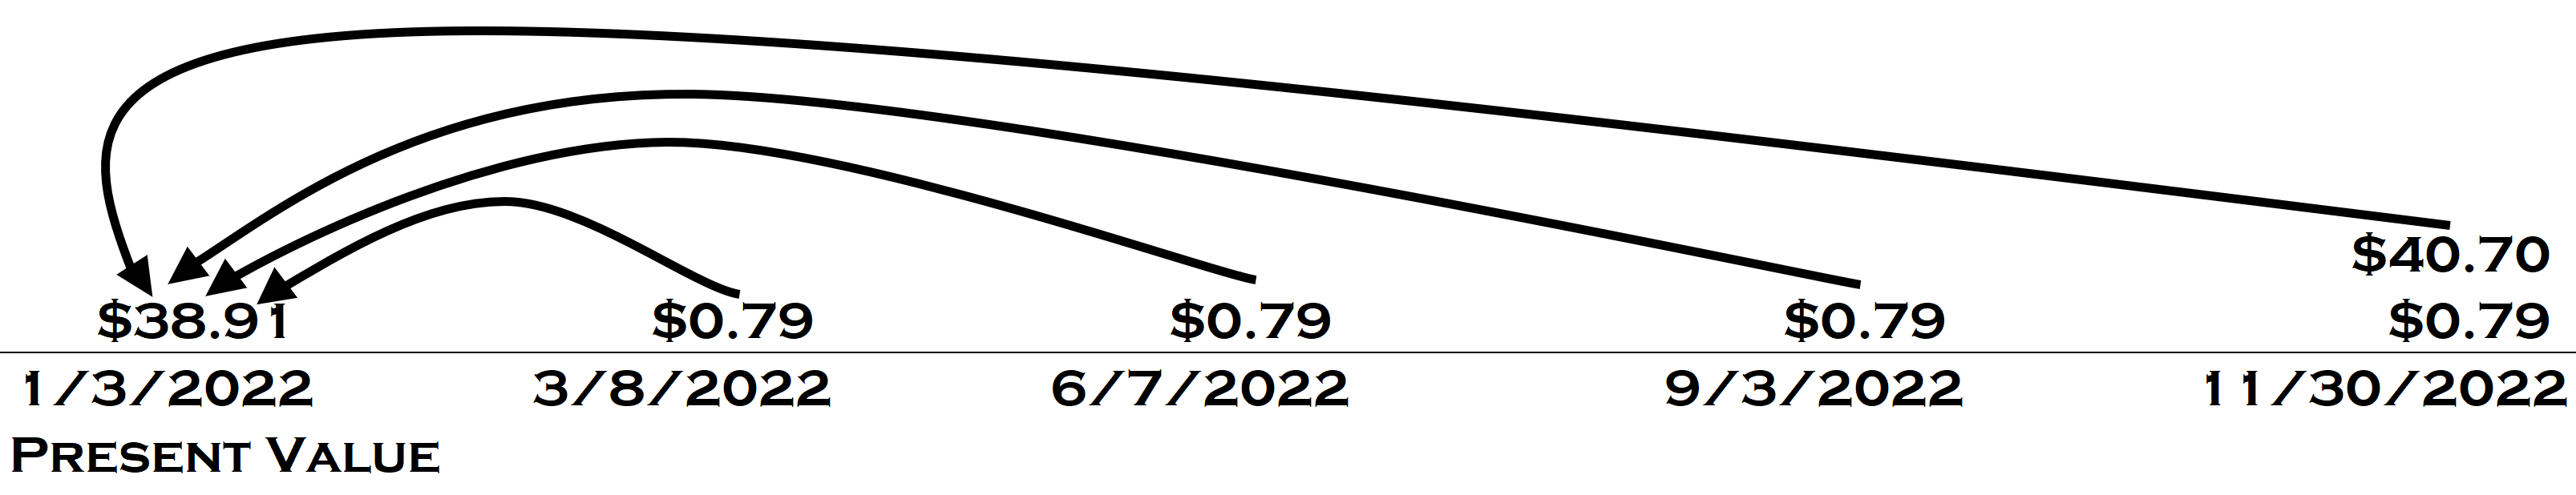

In [42]:
def multi_ddm(ticker,discount_rate,div_growth_rate,time_frame='1y',num_future_dividends = 4, growth_rate=0):
  '''
  Model used to predict the value of a stock given future dividend payments.
  
  discount_rate can be set as the cost of equity.

  div_growth_rate standard input is a company's ROE multiplied by the company's retention ratio.

  Time frames: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max. **Note that if the time frame is changed from the default then the
  num_future_dividends parameter also needs to be changed. For exampe if time_frame = '2y', then set the num_future_dividends to 8.

  growth_rate is an increase in the dividend amount distributed.
  '''
  ticker = yf.Ticker(ticker.upper())
  dividend_history = ticker.history(period=time_frame)['Dividends'][ticker.history(period=time_frame)['Dividends'] != 0]
  dividend_estimate = [dividend_history.mode().iloc[-1]]*num_future_dividends
  pv_factor = [((date + datetime.timedelta(days=365)).to_pydatetime() - datetime.datetime.now()).days/365 for date in  dividend_history.index]
  dividend_growth = [dividend * 1+(growth_rate*factor) for dividend,factor in zip(dividend_estimate,pv_factor)]
  pv_divs = sum([dividend/(1+discount_rate)**factor for factor,dividend in zip(pv_factor,dividend_growth)])
  terminal_value = (dividend_growth[-1] * (1+div_growth_rate)/(discount_rate - div_growth_rate))/(1+discount_rate)**pv_factor[-1]
  return pv_divs+terminal_value

multi_ddm(ticker='swk',discount_rate=cost_of_equity,div_growth_rate=div_growth_rate)

38.90785273039789

In [40]:
ticker = yf.Ticker('SWK')
dividend_history = ticker.history(period='1y')['Dividends'][ticker.history(period='1y')['Dividends'] != 0]
dividend_estimate = [dividend_history.mode().iloc[-1]]*4
pv_factor = [((date + datetime.timedelta(days=365)).to_pydatetime() - datetime.datetime.now()).days/365 for date in  dividend_history.index]
dividend_growth = [dividend * 1+(0*factor) for dividend,factor in zip(dividend_estimate,pv_factor)]
pv_divs = sum([dividend/(1+cost_of_equity)**factor for factor,dividend in zip(pv_factor,dividend_growth)])
terminal_value = (dividend_growth[-1] * (1+div_growth_rate)/(cost_of_equity - div_growth_rate))/(1+cost_of_equity)**pv_factor[-1]
pv_divs + terminal_value

38.90785273039789

In [43]:
mddm_estimates = []

for estimate in market_return_array:
  mddm_estimates.append(multi_ddm(ticker='swk',discount_rate=risk_free_rate + beta * (estimate - risk_free_rate),div_growth_rate=div_growth_rate,time_frame='1y',num_future_dividends = 4, growth_rate=0))

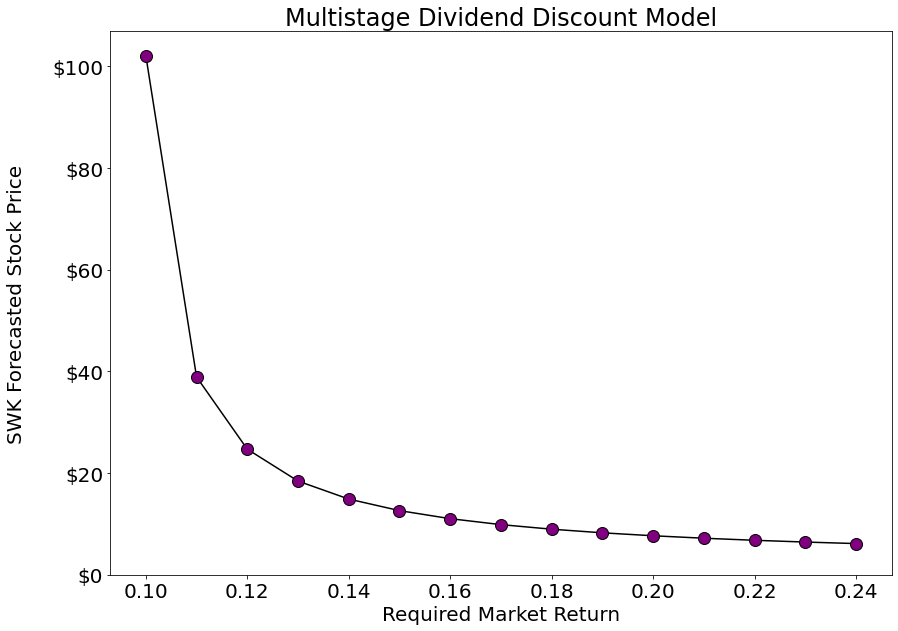

In [44]:
plt.plot(market_return_array,mddm_estimates,color='black', marker='o',markerfacecolor='purple', markevery=1,markersize=12)
plt.ylabel('SWK Forecasted Stock Price\n')
plt.xlabel('Required Market Return')
price_label_2 = ['$'+str(num) for num in range(0,120,20)]
plt.yticks(range(0,120,20),price_label_2)
plt.title('Multistage Dividend Discount Model');

In [45]:
multi_ddm('ibm',discount_rate=.06,div_growth_rate=.05)

162.8325203187769

In [49]:
yf.Ticker('AAPL').get_info()['previousClose']

177.57

In [48]:
multi_ddm('aapl',discount_rate=.06,div_growth_rate=.05)

22.862600163281602

# **References and Additional Learning**

## **Videos**

- **[Dividend discount (Gordon growth) model](https://www.youtube.com/watch?v=cN-sVL7OWcY&ab_channel=BionicTurtle) from Bionic Turtle**

- **[Implementing the DDM in Excel](https://www.youtube.com/watch?v=FBuUchkJT9A&ab_channel=JasonGreene) by Jason Greene**

## **Websites**

- **[Dividend Discount Model – DDM](https://www.investopedia.com/terms/d/ddm.asp) from Investopedia.com by James Chen**

- **[Gordon Growth Model](https://www.investopedia.com/terms/g/gordongrowthmodel.asp) from Investopedia.com by Adam Hayes**

- **[Multistage Dividend Discount Model](https://www.investopedia.com/terms/m/multistageddm.asp) from Investopedia.com by James Chen**

- **[The Stable Growth DDM: Gordon Growth Model](https://www.investopedia.com/terms/d/ddm.asp) by Aswath Damodaran**

- **[yfinance documentation](https://github.com/ranaroussi/yfinance) on GitHub**

# **Connect**
- **Feel free to connect with Adrian on [YouTube](https://www.youtube.com/channel/UCPuDxI3xb_ryUUMfkm0jsRA), [LinkedIn](https://www.linkedin.com/in/adrian-dolinay-frm-96a289106/), [Twitter](https://twitter.com/DolinayG) and [GitHub](https://github.com/ad17171717). Happy coding!**